# Analysis: Impact of Chatbot Usage on Student Performance

This notebook analyzes whether daily chatbot usage (`message_count`) influences students' performance scores using a Linear Mixed-Effects Model.

We use two datasets:
- `performances.csv`: test outcomes
- `user_days.csv`: daily chatbot activity and learning behavior

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import ast

# Load data
performances = pd.read_csv("data/features/performances.csv")
user_days = pd.read_csv("data/features/user_days.csv")

# Convert dates
performances["date"] = pd.to_datetime(performances["date"])
user_days["date"] = pd.to_datetime(user_days["date"])

In [2]:
performances.head()

,user_id,domain,test_id,course,date,time,percentage,performance
0,1,essay,eroerterung,3301,2024-11-29,2024-11-29 23:52:33,63.000000,-7.090000
1,1,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:24:30,55.294118,-8.075882
2,4,essay,eroerterung,3301,2024-11-21,2024-11-21 17:23:46,66.000000,-4.090000
3,4,essay,erzaehlung,3301,2024-11-07,2024-11-07 16:13:25,71.000000,3.390000
4,5,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:23:58,44.705882,-18.664118


In [3]:
user_days.head()

,user_id,date,type,user_day,number_of_activities,domain,activity_type,time_in_minutes,message_count
0,1,2024-10-26,both,1.0,2.0,essay,lesson,0.0,NaN
1,1,2024-10-30,activity,2.0,0.0,NaN,NaN,NaN,NaN
2,1,2024-10-31,activity,3.0,1.0,text,lesson,0.0,NaN
3,1,2024-11-01,activity,4.0,6.0,essay,lesson,0.0,NaN
4,1,2024-11-01,activity,4.0,6.0,text,lesson,0.0,NaN


### Mapping 

In [4]:
mapping = pd.read_csv("data/original/mapping.csv")
gymitrainer = pd.read_csv("data/original/gymitrainer.csv")

print(mapping.shape[0])
mapping.head()

8408


,Unnamed: 0,user_id,delta,confidence,id
0,0,282,1039460,0.200156,c40e9e5f-39fa-415d-b806-69846ea659b3
1,1,282,1038323,0.200156,78a59adc-96b4-44c7-aad6-f669c944794e
2,2,282,966940,0.200168,419631b2-5dbb-4b1d-b323-b3c758c4933d
3,3,282,966558,0.200168,c2b07040-8023-4c68-bf45-0f7ab0a33b38
4,4,282,965864,0.200168,9d9501ba-732d-49e5-b40c-ba261a0db18f


In [5]:
print('nb of interactions :',gymitrainer.shape[0])
gymitrainer.head()

nb of interactions : 8245


,Unnamed: 0,id,chat_profile,tag,message_count,startTime,endTime,content
0,0,8d8b7ed3-393a-4fff-a3de-3cd515399efa,NaN,NaN,0,1741330528,1741330535,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
1,1,f27276e8-eca8-419e-8f13-1677aac6c5b8,NaN,NaN,0,1741330363,1741330368,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
2,2,b870f1ce-6fd3-4353-96c3-7fb44c9add19,NaN,NaN,0,1741330310,1741330326,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
3,3,873d766b-baf9-4c88-a27b-9f842df763d8,NaN,NaN,0,1741330270,1741330294,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor..."
4,4,2c470a15-7dc4-4b83-be81-61501b325d0d,NaN,NaN,0,1741123788,1741123799,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor..."


In [6]:
gymitrainer_with_users = pd.merge(gymitrainer,mapping,  on='id',how='left')
gymitrainer_with_users = gymitrainer_with_users[gymitrainer_with_users['message_count'] > 0]

print('nb of chats :' , gymitrainer_with_users.shape[0])
print('nb of chats with confidence > 0.4:' , gymitrainer_with_users[gymitrainer_with_users['confidence']>0.4].shape[0])
print('nb of chats with confidence > 0.69:' , gymitrainer_with_users[gymitrainer_with_users['confidence']>0.69].shape[0])

nb of chats : 7707
nb of chats with confidence > 0.4: 3500
nb of chats with confidence > 0.69: 1612


In [7]:
### For the following analysis we will use > 0.4 confidence data :

gymitrainer_with_users = gymitrainer_with_users[gymitrainer_with_users['confidence'] > 0.4][['user_id', 'chat_profile', 'tag', 'startTime', 'endTime', 'content', 'message_count', 'confidence']]


gymitrainer_with_users = gymitrainer_with_users.copy()
gymitrainer_with_users["startTime"] = pd.to_datetime(gymitrainer_with_users["startTime"], unit="s")
gymitrainer_with_users["endTime"] = pd.to_datetime(gymitrainer_with_users["endTime"], unit="s")

gymitrainer_with_users.head()

,user_id,chat_profile,tag,startTime,endTime,content,message_count,confidence
7,246,NaN,NaN,2025-03-04 12:55:19,2025-03-04 12:58:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",3,0.961883
12,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:31:08,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514
13,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:29:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",2,0.952514
14,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:26:38,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514
15,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:17:56,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514


In [8]:
gymitrainer_with_users.to_csv('data/cleaned/gymitrainer_40percent.csv')

In [9]:
#gymitrainer_with_users = pd.read_csv('data/cleaned/gymitrainer_40percent.csv')

### Feature extraction

**All features are calculated for the 7 days prior to an exam**

- Total number of chatbot sessions

- Total number of messages exchanged

- Total time spent with chatbot (sum of durations)

- Number of messages on day of exam

- Number of messages on day before the exam



In [10]:
performances['perf_score'] = (performances['performance'] > 0).astype(int)

performances.head()

,user_id,domain,test_id,course,date,time,percentage,performance,perf_score
0,1,essay,eroerterung,3301,2024-11-29,2024-11-29 23:52:33,63.000000,-7.090000,0
1,1,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:24:30,55.294118,-8.075882,0
2,4,essay,eroerterung,3301,2024-11-21,2024-11-21 17:23:46,66.000000,-4.090000,0
3,4,essay,erzaehlung,3301,2024-11-07,2024-11-07 16:13:25,71.000000,3.390000,1
4,5,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:23:58,44.705882,-18.664118,0


In [11]:
gymitrainer_with_users.head()

,user_id,chat_profile,tag,startTime,endTime,content,message_count,confidence
7,246,NaN,NaN,2025-03-04 12:55:19,2025-03-04 12:58:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",3,0.961883
12,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:31:08,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514
13,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:29:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",2,0.952514
14,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:26:38,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514
15,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:17:56,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514


In [12]:
def compute_chatbot_features_for_exam(user_id, exam_date, gym_data):
    
    user_data = gym_data[gym_data['user_id'] == user_id]

    # Filter: 7 days before exam (inclusive)
    start_window = exam_date - pd.Timedelta(days=7)
    end_window = exam_date
    
    data_window = user_data[(user_data['startTime'] >= start_window) & (user_data['startTime'] < end_window)]

    # Messages on day before exam
    day_before = exam_date - pd.Timedelta(days=1)
    msgs_day_before = user_data[user_data['startTime'].dt.date == day_before.date()]['message_count'].sum()

    # Messages on exam day
    msgs_exam_day = user_data[user_data['startTime'].dt.date == exam_date.date()]['message_count'].sum()

    # Average length of conversation 
    avg_length_conv = data_window['content'].apply(lambda x: ast.literal_eval(x)[1::2])
    avg_length_conv = data_window['content'].apply(lambda x: sum(len(s) for s in ast.literal_eval(x)[1::2])).mean()

    # Used chatbot last 7 days?
    used_chatbot_last_7_days = 0
    if len(data_window) > 0 :
        used_chatbot_last_7_days = 1

    
    return {
        'used_chatbot_last_7_days' : used_chatbot_last_7_days,
        'avg_length_conv' : avg_length_conv,
        'n_sessions_last_7_days': len(data_window),
        'n_messages_last_7_days': data_window['message_count'].sum(),
        'total_duration_last_7_days': (data_window['endTime'] - data_window['startTime']).dt.total_seconds().sum(),
        'n_messages_day_before_exam': msgs_day_before,
        'n_messages_on_exam_day': msgs_exam_day
    }

In [13]:
features_list = []

for _, row in performances.iterrows():

    user_id = row['user_id']
    exam_date = row['date']

    features = compute_chatbot_features_for_exam(user_id, exam_date, gymitrainer_with_users)

    features['user_id'] = user_id
    features['exam_date'] = exam_date
    features['test_id'] = row['test_id']
    features['perf_score'] = row['perf_score'] 

    features_list.append(features)

exam_features_df = pd.DataFrame(features_list)

exam_features_df.head()


,used_chatbot_last_7_days,avg_length_conv,n_sessions_last_7_days,n_messages_last_7_days,total_duration_last_7_days,n_messages_day_before_exam,n_messages_on_exam_day,user_id,exam_date,test_id,perf_score
0,1,1975.0,1,8,767.0,0,0,1,2024-11-29,eroerterung,0
1,0,NaN,0,0,0.0,0,0,1,2024-10-26,erzaehlung,0
2,0,NaN,0,0,0.0,0,0,4,2024-11-21,eroerterung,0
3,0,NaN,0,0,0.0,0,0,4,2024-11-07,erzaehlung,1
4,0,NaN,0,0,0.0,0,0,5,2024-10-26,erzaehlung,0


## Model

We use a random forest classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
### We first try with all users including those that did not use the chatbot at all 

use_features = [
    'n_sessions_last_7_days',
    'avg_length_conv',
    'n_messages_last_7_days',
    'total_duration_last_7_days',
    'n_messages_day_before_exam',
    'n_messages_on_exam_day'
]

all_users = exam_features_df.copy()

# Step 3: Prepare features (X) and target (y)
X_intensity = all_users[use_features]
y_intensity = all_users['perf_score']  # Binary target: 1 if perf > 0, else 0

# Step 4: Split into train and test sets
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_intensity, y_intensity, test_size=0.2, random_state=42
)

# Step 5: Train the Random Forest Classifier
intensity_model = RandomForestClassifier(random_state=42)
intensity_model.fit(X_train_int, y_train_int)

# Step 6: Make predictions on the test set
y_pred = intensity_model.predict(X_test_int)

# Step 7: Evaluate model performance
accuracy = accuracy_score(y_test_int, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_int, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_int, y_pred))

Accuracy: 0.5630

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.83      0.65       481
           1       0.64      0.30      0.41       487

    accuracy                           0.56       968
   macro avg       0.59      0.56      0.53       968
weighted avg       0.59      0.56      0.53       968


Confusion Matrix:
[[397  84]
 [339 148]]


In [16]:
### Now we only concentrate on users of the chatbot to see if we can model what "good" usage is 

use_features = [
    'n_sessions_last_7_days',
    'avg_length_conv',
    'n_messages_last_7_days',
    'total_duration_last_7_days',
    'n_messages_day_before_exam',
    'n_messages_on_exam_day'
]

# Step 2: Subset data to users who used the chatbot
chatbot_users = exam_features_df[exam_features_df['used_chatbot_last_7_days'] == 1]

# Step 3: Prepare features (X) and target (y)
X_intensity = chatbot_users[use_features]
y_intensity = chatbot_users['perf_score']  # Binary target: 1 if perf > 0, else 0

# Step 4: Split into train and test sets
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_intensity, y_intensity, test_size=0.2, random_state=42
)

# Step 5: Train the Random Forest Classifier
intensity_model = RandomForestClassifier(random_state=42)
intensity_model.fit(X_train_int, y_train_int)

# Step 6: Make predictions on the test set
y_pred = intensity_model.predict(X_test_int)

# Step 7: Evaluate model performance
accuracy = accuracy_score(y_test_int, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_int, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_int, y_pred))

Accuracy: 0.6895

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64       116
           1       0.75      0.71      0.73       161

    accuracy                           0.69       277
   macro avg       0.68      0.69      0.68       277
weighted avg       0.69      0.69      0.69       277


Confusion Matrix:
[[ 77  39]
 [ 47 114]]



Feature Importances:
                      feature  importance
3  total_duration_last_7_days    0.322108
1             avg_length_conv    0.291351
2      n_messages_last_7_days    0.135275
5      n_messages_on_exam_day    0.100772
0      n_sessions_last_7_days    0.077600
4  n_messages_day_before_exam    0.072895


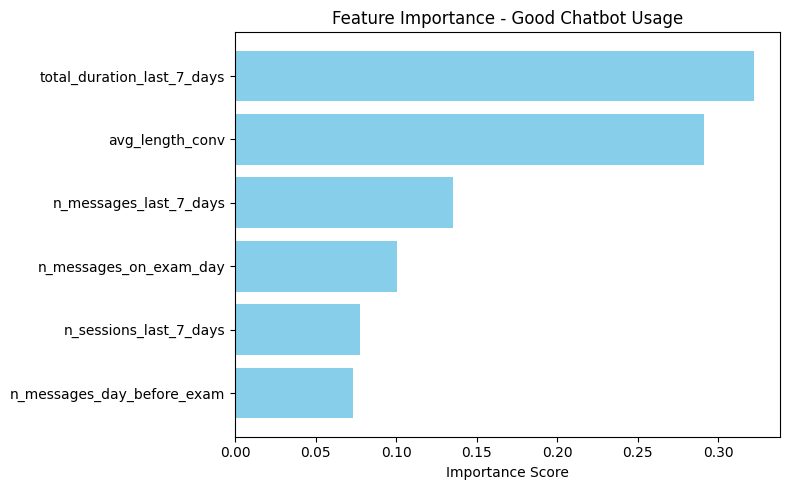

In [18]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = intensity_model.feature_importances_

# Create a DataFrame for better readability
importance_df = pd.DataFrame({
    'feature': use_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Print ranked feature importances
print("\nFeature Importances:")
print(importance_df)

# Optional: plot
plt.figure(figsize=(8, 5))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest on top
plt.xlabel('Importance Score')
plt.title('Feature Importance - Good Chatbot Usage')
plt.tight_layout()
plt.show()

The y-axis shows the average predicted probability of the positive class (e.g., perf_score = 1) when you vary only this feature, holding all other features fixed.

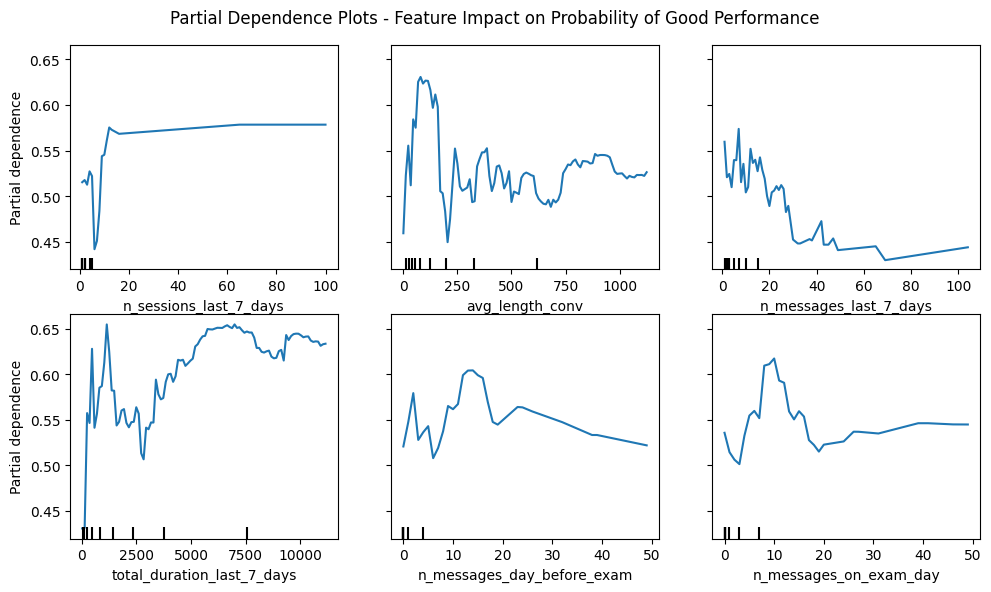

In [19]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(intensity_model, X_train_int, features=use_features, ax=ax)
plt.suptitle('Partial Dependence Plots - Feature Impact on Probability of Good Performance')
plt.tight_layout()
plt.show()

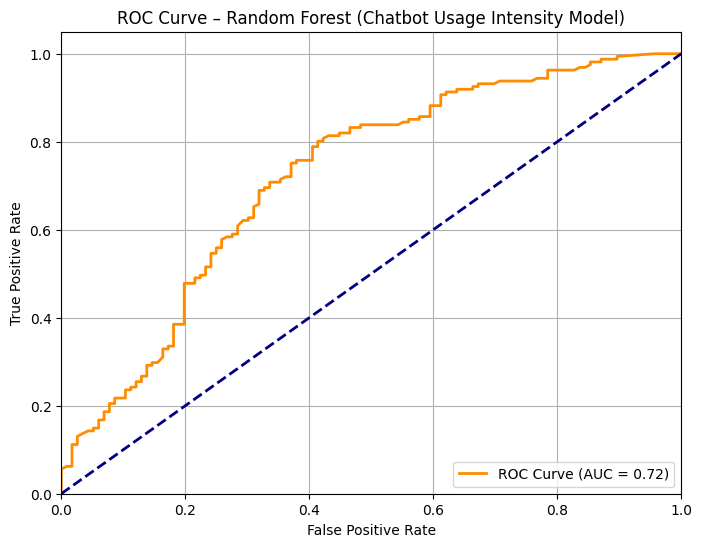

In [20]:
from sklearn.metrics import roc_curve, auc

# Step 1: Predict probabilities for the positive class (class 1)
y_proba = intensity_model.predict_proba(X_test_int)[:, 1]

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_int, y_proba)
roc_auc = auc(fpr, tpr)

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest (Chatbot Usage Intensity Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

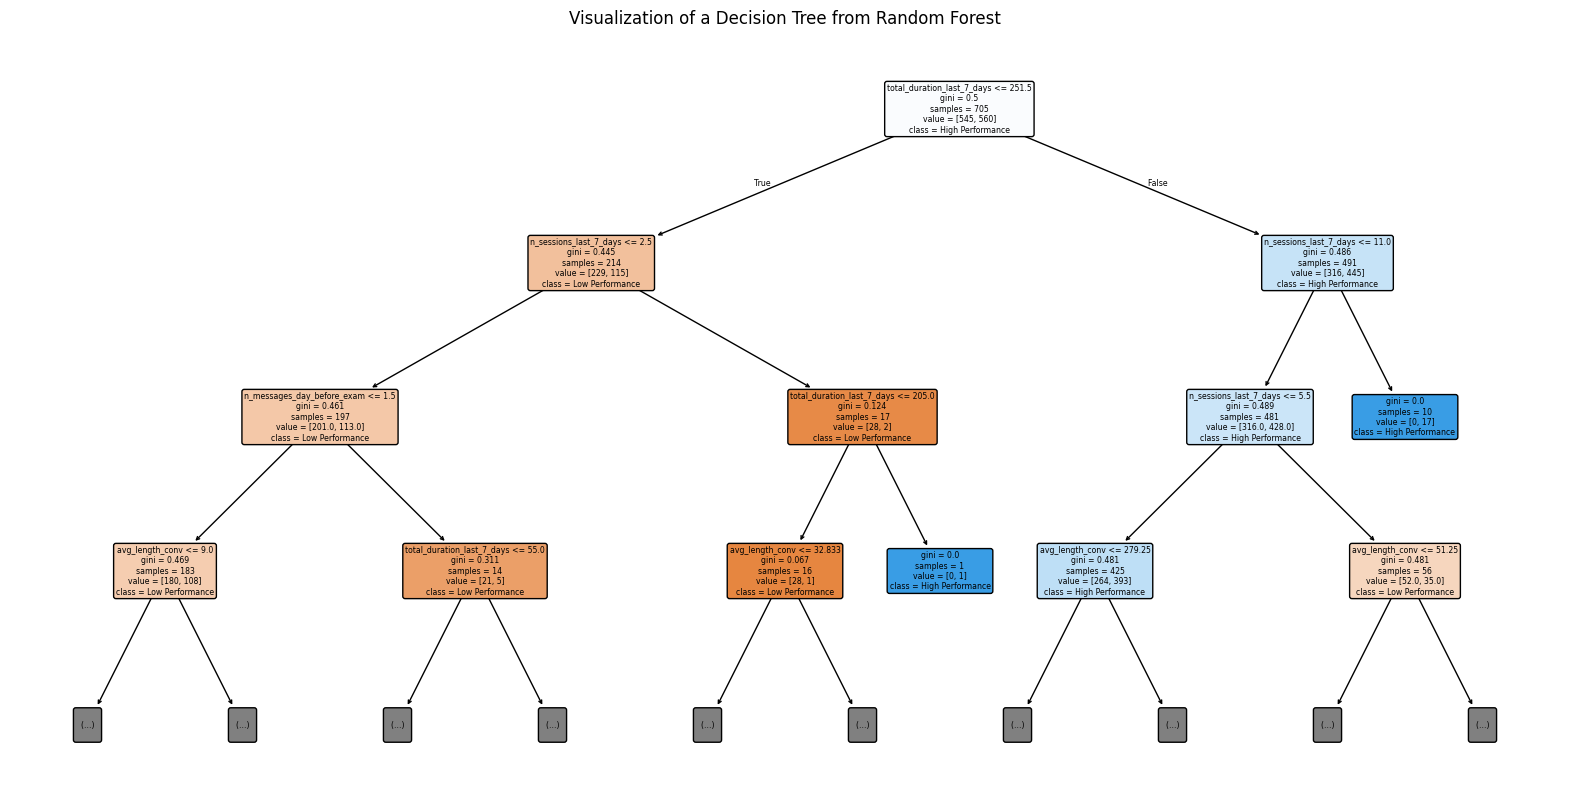

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Choose one tree from the forest (e.g., the first one)
estimator = intensity_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(
    estimator,
    feature_names=use_features,
    class_names=['Low Performance', 'High Performance'],
    filled=True,
    rounded=True,
    max_depth=3  # optional: limit depth for readability
)
plt.title("Visualization of a Decision Tree from Random Forest")
plt.show()

In [22]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Step 3: Prepare features (X) and target (y)
X_intensity = chatbot_users[use_features]
y_intensity = chatbot_users['perf_score']  # Binary target: 1 if perf > 0, else 0


# Use stratified CV to preserve class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Reuse your existing model
cv_scores = cross_val_score(intensity_model, X_intensity, y_intensity, cv=skf, scoring='accuracy')

print("Stratified CV Accuracy Scores:", cv_scores)
print(f"Average Stratified CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Stratified CV Accuracy Scores: [0.6534296  0.63898917 0.59782609 0.62318841 0.61594203]
Average Stratified CV Accuracy: 0.6259
Standard Deviation: 0.0191
